<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/LSPD_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [28]:
# !pip install yfinance
!pip install --upgrade yfinance==0.2.54
!pip install plotly
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet
import plotly.io as pio
import warnings
import itertools
import logging
from prophet.diagnostics import cross_validation, performance_metrics
pio.renderers.default='colab'
warnings.filterwarnings("ignore")

## Importing the Dataset & Exploring it

In [29]:
 # Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '5y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: LSPD.TO
You entered LSPD.TO, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1246,2025-02-06 00:00:00-05:00,18.500000,18.650000,16.930000,18.040001,4025400,0.0,0.0
1247,2025-02-07 00:00:00-05:00,17.820000,18.820000,17.590000,18.760000,1380600,0.0,0.0
1248,2025-02-10 00:00:00-05:00,18.820000,19.150000,18.600000,19.040001,822100,0.0,0.0
1249,2025-02-11 00:00:00-05:00,18.840000,19.090000,18.330000,18.770000,916600,0.0,0.0
1250,2025-02-12 00:00:00-05:00,18.500000,19.170000,18.500000,18.889999,969500,0.0,0.0
1251,2025-02-13 00:00:00-05:00,18.920000,19.379999,18.860001,19.000000,567600,0.0,0.0
1252,2025-02-14 00:00:00-05:00,19.000000,19.190001,18.700001,19.170000,830400,0.0,0.0
1253,2025-02-18 00:00:00-05:00,19.209999,19.670000,19.180000,19.469999,615400,0.0,0.0
1254,2025-02-19 00:00:00-05:00,19.809999,19.889999,19.260000,19.389999,905500,0.0,0.0
1255,2025-02-20 00:00:00-05:00,19.200001,19.209999,18.719999,19.020000,1592573,0.0,0.0


In [30]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03,1256.0,1256.0
mean,40.761879,41.750012,39.708069,40.729275,8.827162e+05,0.0,0.0
std,31.535294,32.222261,30.804638,31.548232,6.345781e+05,0.0,0.0
min,11.860000,13.690000,10.500000,12.000000,7.130000e+04,0.0,0.0
25%,20.397500,20.897500,20.063750,20.435000,4.818750e+05,0.0,0.0
50%,24.964999,25.815000,24.472501,25.075000,7.225000e+05,0.0,0.0
75%,45.342501,46.092502,43.910001,45.337500,1.122450e+06,0.0,0.0
max,160.940002,165.869995,157.130005,158.929993,1.036830e+07,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [31]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [32]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [33]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [34]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [35]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [36]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 60, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = pd.concat([hurst, pd.DataFrame([{"hurst_exp":hurst_exp,"lag":lag}])], ignore_index=True)
warnings.filterwarnings("ignore")
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [37]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df=prophet_df.rename(columns={'Date':'ds','Close':'y'})
prophet_df['ds']=prophet_df['ds'].dt.tz_localize(None)
prophet_df.tail()

,ds,y
1251,2025-02-13,19.000000
1252,2025-02-14,19.170000
1253,2025-02-18,19.469999
1254,2025-02-19,19.389999
1255,2025-02-20,19.020000


In [38]:
cutoffs =  pd.to_datetime(pd.date_range(end='today', periods=5, freq='Y', normalize=True))
cutoffs

DatetimeIndex(['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31',
               '2024-12-31'],
              dtype='datetime64[ns]', freq='YE-DEC')

## Hyperparameter tuning

In [39]:
# Ignore logs
logging.getLogger("cmdstanpy").disabled = True

# Year end cut-offs for 5 years periods
cutoffs =  pd.to_datetime(pd.date_range(end='today', periods=5, freq='Y', normalize=True))

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, daily_seasonality=False).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='45 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e38d308ba50>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e38d3d32850>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e38d30f26d0>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e38d3091a90>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e38d2fea190>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e38d30912d0>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e38d30a0a50>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e38d5ea40d0>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at

In [40]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  45.043056
1                     0.001                     0.10  50.802109
2                     0.001                     1.00  48.788404
3                     0.001                    10.00  48.777444
4                     0.010                     0.01  42.862102
5                     0.010                     0.10  47.935650
6                     0.010                     1.00  47.621011
7                     0.010                    10.00  47.778599
8                     0.100                     0.01   6.491335
9                     0.100                     0.10  10.876687
10                    0.100                     1.00  11.075057
11                    0.100                    10.00  11.583743
12                    0.500                     0.01   8.758602
13                    0.500                     0.10   9.114432
14                    0.500             

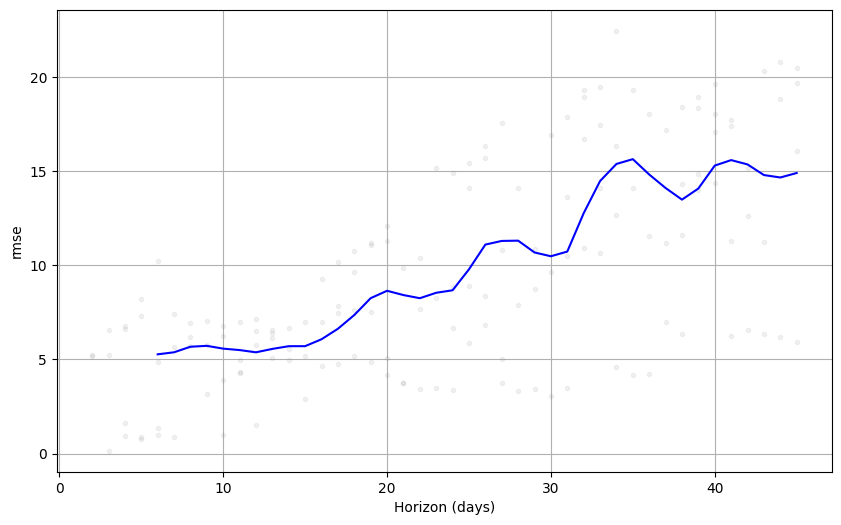

In [41]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')


## Creating Facebook Prophet Model

In [42]:
m=Prophet(**best_params,daily_seasonality=False)
m.fit(prophet_df)

##Forecasting

In [43]:
periods = 60
future=m.make_future_dataframe(periods)

In [44]:
forecast=m.predict(future)

In [45]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-20,25.267326,22.095366,33.536668,25.267326,25.267326,2.401638,2.401638,2.401638,-0.000536,-0.000536,-0.000536,2.402173,2.402173,2.402173,0.0,0.0,0.0,27.668963
1,2020-02-21,25.280835,21.735901,33.831490,25.280835,25.280835,2.166947,2.166947,2.166947,-0.028130,-0.028130,-0.028130,2.195077,2.195077,2.195077,0.0,0.0,0.0,27.447782
2,2020-02-24,25.321362,21.058928,32.575535,25.321362,25.321362,1.531340,1.531340,1.531340,0.053049,0.053049,0.053049,1.478291,1.478291,1.478291,0.0,0.0,0.0,26.852702
3,2020-02-25,25.334871,20.757257,32.622035,25.334871,25.334871,1.277982,1.277982,1.277982,0.063575,0.063575,0.063575,1.214406,1.214406,1.214406,0.0,0.0,0.0,26.612852
4,2020-02-26,25.348380,20.652562,31.647121,25.348380,25.348380,0.888736,0.888736,0.888736,-0.053055,-0.053055,-0.053055,0.941790,0.941790,0.941790,0.0,0.0,0.0,26.237115
5,2020-02-27,25.361889,20.512421,31.537150,25.361889,25.361889,0.662239,0.662239,0.662239,-0.000536,-0.000536,-0.000536,0.662774,0.662774,0.662774,0.0,0.0,0.0,26.024127
6,2020-02-28,25.375398,20.084000,31.266073,25.375398,25.375398,0.351552,0.351552,0.351552,-0.028130,-0.028130,-0.028130,0.379682,0.379682,0.379682,0.0,0.0,0.0,25.726950
7,2020-03-02,25.415925,19.456680,30.675273,25.415925,25.415925,-0.418672,-0.418672,-0.418672,0.053049,0.053049,0.053049,-0.471721,-0.471721,-0.471721,0.0,0.0,0.0,24.997253
8,2020-03-03,25.429434,18.745933,30.663811,25.429434,25.429434,-0.685723,-0.685723,-0.685723,0.063575,0.063575,0.063575,-0.749299,-0.749299,-0.749299,0.0,0.0,0.0,24.743710
9,2020-03-04,25.442942,18.591054,30.485479,25.442942,25.442942,-1.073684,-1.073684,-1.073684,-0.053055,-0.053055,-0.053055,-1.020630,-1.020630,-1.020630,0.0,0.0,0.0,24.369258


In [46]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

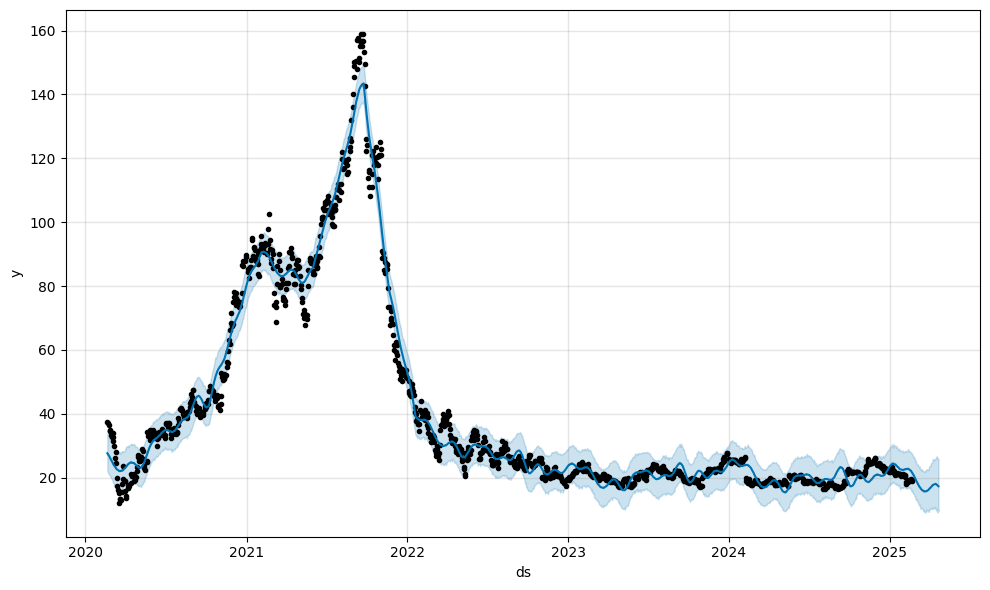

In [47]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

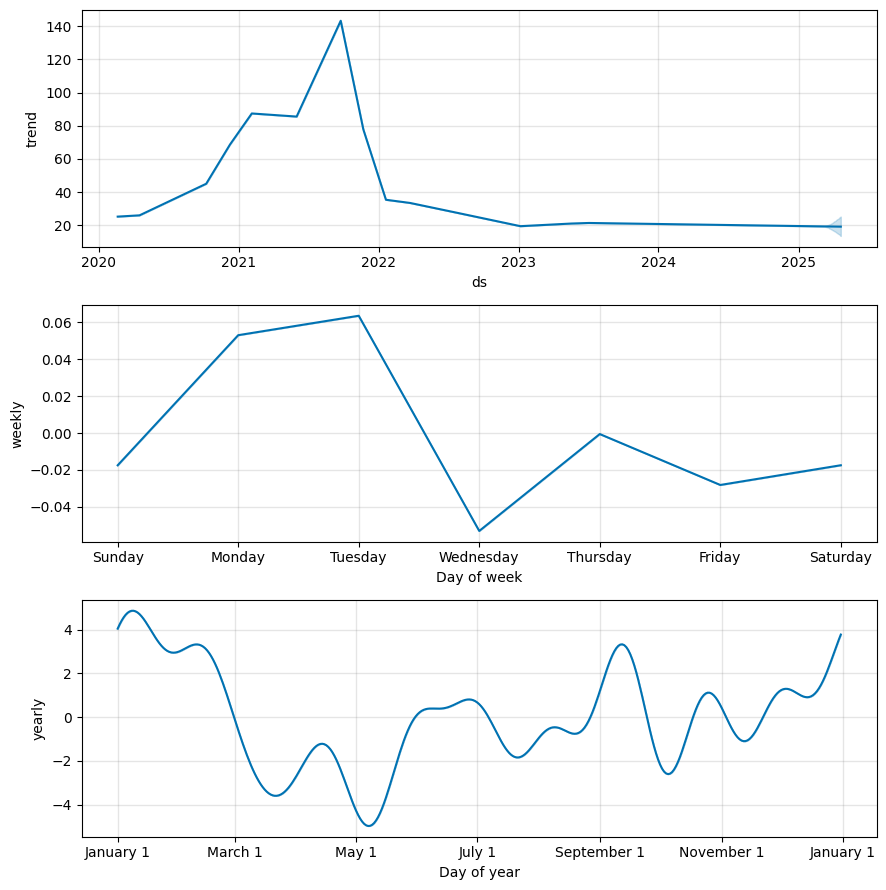

In [48]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [49]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>